### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with Metabolights data: 
#### Flow Cytometry Has a Significant Impact on the Cellular Metabolome

Article link: https://pubs.acs.org/doi/10.1021/acs.jproteome.8b00472

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS629

Four groups of thioglycollate-induced peritoneal macrohpages with five biological replicates each (n = 20).
- Ctrl - peritoneal lavage pelleted cells immediately snap-frozen in liquid nitrogen upon isolation.
- Ab (Antibody) - peritoneal macrophages subjected to immunostaining and subsequently stored in liquid N2 without sorting.
- Sort - freshly isolated macrophages immediately analyzed by flow cytometry without ab labeling and with sorting of the complete cell pop. into the collection tube.
- Ab+Sort - freshly isolated cells immunostained and then sorted by flow cytometry, with collection of the complete cell population.

Metabolomics approach:
- LC–ESI–QTOF–MS methods, CE-ESI–-TOF–MS, and GC–EI-Q–MS. 
- Two reference masses 121.0509 (purine, detected m/z [C5H4N4+H]+) and 922.0098 (HP,detected m/z [C18H18O6N3P3F24+H]+).
- Obtained in ESI positive and negative modes.
- Data from LC-ESI-QTOF-MS. 

Supplementary Information has a lot of information. 

Data characteristics:
- Most of the features of the data seemed to have been filtered (like many of the Metabolights datasets that were thus not usable), however, in this case, features seemed to have been filtered with some emphasis on feature presence or not in the group of samples, generating a skewed dataset where binary measures should perform better. 

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

## Similarity analysis

aligned_all_neg = negative dataset or derived from the negative dataset.

aligned_pos = positive dataset or derived from the positive dataset.

#### Read aligned data and transformation into a DataFrame (zeros replaced as missing values)

In [3]:
file = pd.read_table('Metabolights/m_mtbls629_NEG_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')
file = file[file.columns[21:]]

labels = ["CTRL","CTRL","CTRL","CTRL","CTRL","AB","AB","AB","AB","AB",
        "SORT","SORT","SORT","SORT","SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT"]
aligned_file = mtl.add_labels(file, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_neg = aligned_file.replace({0:np.nan})

In [4]:
aligned_all_neg

label       CTRL                                                       \
       Ctrl1_neg  Ctrl2_neg     Ctrl3_neg     Ctrl4_neg     Ctrl5_neg   
0      5426183.0  5991088.0  7.717718e+06  8.612450e+06  7.203798e+06   
1        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
2        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
3        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
4            NaN        NaN           NaN           NaN           NaN   
..           ...        ...           ...           ...           ...   
76      597445.0   278434.0  2.258870e+05  2.288040e+05  1.297140e+05   
77      864507.0   848432.0  8.056110e+05  6.824130e+05  9.524080e+05   
78      864507.0   848432.0  8.056110e+05  6.824130e+05  9.524080e+05   
79       99188.0    49791.0  4.991600e+04  4.903700e+04  3.696700e+04   
80      183996.0   111202.0  1.041170e+05  8.033785e+04  6.043100e+04   

label         AB                                                         SORT  \
         Ab1_neg       Ab2_neg    Ab3_neg    Ab4_neg       Ab5_neg  Sort1_neg   
0      6031306.0  7.025290e+06  5755462.0  9006708.0  8.171638e+06  2801078.0   
1            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
2            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
3            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
4         6762.0  2.094000e+03     2094.0    41847.0  1.397771e+04     8215.0   
..           ...           ...        ...        ...           ...        ...   
76      614886.0  2.792700e+05   190702.0   121110.0  2.300600e+05   339422.0   
77     1001383.0  6.201230e+05   594368.0   594871.0  5.979400e+05   651220.0   
78     1001383.0  6.201230e+05   594368.0   594871.0  5.979400e+05   651220.0   
79       95676.0  4.853932e+04    36766.0    48299.0  4.869400e+04    46058.0   
80           NaN  1.003670e+05        NaN        NaN           NaN    89915.0   

label                                                               AB+SORT  \
          Sort2_neg     Sort3_neg     Sort4_neg     Sort5_neg  Ab+Sort1_neg   
0      5.917181e+06  1.572602e+07  3.887523e+06  5.003216e+06  5.197312e+06   
1               NaN           NaN           NaN  5.308000e+03           NaN   
2               NaN           NaN           NaN  5.308000e+03           NaN   
3               NaN           NaN           NaN  5.308000e+03           NaN   
4      2.082400e+04  8.215000e+03  1.720281e+04  2.395400e+04  1.347400e+04   
..              ...           ...           ...           ...           ...   
76     5.477400e+04  6.728600e+04  5.971300e+04  7.706000e+04  2.130780e+05   
77     6.012870e+05  5.636600e+05  3.224080e+05  3.359560e+05  5.181090e+05   
78     6.012870e+05  5.636600e+05  3.224080e+05  3.359560e+05  5.181090e+05   
79     1.647200e+04  2.838800e+04  2.027264e+04  2.659900e+04  4.272300e+04   
80     2.214710e+04  1.594368e+04  3.435000e+04  1.797101e+04  4.433542e+04   

label                                                          
       Ab+Sort2_neg  Ab+Sort3_neg  Ab+Sort4_neg  Ab+Sort5_neg  
0      5.093217e+06  2.303014e+06  1.160924e+06  2.570561e+06  
1               NaN           NaN           NaN           NaN  
2               NaN           NaN           NaN           NaN  
3               NaN           NaN           NaN           NaN  
4      2.207100e+04  1.347400e+04  1.347400e+04  1.002100e+04  
..              ...           ...           ...           ...  
76     6.466700e+04  1.054800e+05  8.045100e+04  2.133000e+04  
77     2.857124e+05  3.503950e+05  2.601550e+05  1.675570e+05  
78     2.857124e+05  3.503950e+05  2.601550e+05  1.675570e+05  
79     2.133300e+04  3.587845e+04  1.534459e+04  1.060665e+04  
80     5.126600e+04  4.175400e+04  2.821200e+04  3.967432e+04  

[81 rows x 20 columns]

In [5]:
file = pd.read_table('Metabolights/m_mtbls629_POS_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')
file = file[file.columns[21:]]

labels = ["CTRL","CTRL","CTRL","CTRL","CTRL","AB","AB","AB","AB","AB",
        "SORT","SORT","SORT","SORT","SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT"]
aligned_file = mtl.add_labels(file, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_pos = aligned_file.replace({0:np.nan})

In [6]:
aligned_all_pos

label         CTRL                                                         AB  \
         Ctrl1_pos   Ctrl2_pos Ctrl3_pos Ctrl4_pos    Ctrl5_pos       Ab1_pos   
0              NaN         NaN       NaN       NaN          NaN           NaN   
1       15641.0000   13081.000   13222.0   10311.0    8112.0000           NaN   
2              NaN         NaN       NaN       NaN          NaN           NaN   
3              NaN         NaN       NaN       NaN          NaN           NaN   
4              NaN         NaN       NaN       NaN          NaN           NaN   
..             ...         ...       ...       ...          ...           ...   
94     133795.0000  194686.712  339793.0       NaN          NaN  2.687506e+06   
95             NaN         NaN       NaN       NaN          NaN  1.402457e+06   
96     143880.6048  119010.000  156454.0  131081.0  127030.9584  7.137470e+04   
97      16560.0000         NaN       NaN       NaN          NaN  6.657899e+04   
98     520613.0000  405177.000  432468.0  362373.0  315210.0000  4.828880e+05   

label                                                         SORT            \
         Ab2_pos    Ab3_pos       Ab4_pos       Ab5_pos  Sort1_pos Sort2_pos   
0            NaN        NaN           NaN           NaN        NaN   41559.0   
1            NaN        NaN           NaN           NaN        NaN       NaN   
2            NaN        NaN           NaN           NaN    85480.0   61826.0   
3            NaN        NaN           NaN           NaN    85480.0   61826.0   
4            NaN        NaN           NaN           NaN    85480.0   61826.0   
..           ...        ...           ...           ...        ...       ...   
94           NaN        NaN           NaN           NaN   431317.0  475497.0   
95     2106965.0  2528845.0  2.106965e+06  2.106965e+06  3843629.0       NaN   
96      139135.0   138200.0  6.207601e+04  6.332448e+04        NaN       NaN   
97       71107.0    69387.0  6.575324e+04  6.155400e+04        NaN       NaN   
98      400541.0   316450.0  3.420110e+05  3.712960e+05   286450.0  194861.0   

label                                         AB+SORT               \
      Sort3_pos     Sort4_pos Sort5_pos  Ab+Sort1_pos Ab+Sort2_pos   
0           NaN           NaN       NaN  1.276176e+06      44810.0   
1           NaN           NaN       NaN           NaN          NaN   
2       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
3       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
4       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
..          ...           ...       ...           ...          ...   
94     380997.0  475497.00000  475497.0           NaN          NaN   
95          NaN           NaN       NaN  2.218701e+06     488612.0   
96      73651.0           NaN       NaN           NaN          NaN   
97          NaN           NaN       NaN  5.762720e+04      33811.0   
98     285086.0  193499.00000  235850.0  3.670210e+05     249374.0   

label                                            
       Ab+Sort3_pos  Ab+Sort4_pos  Ab+Sort5_pos  
0      1.734822e+06  519215.42900   26305.00000  
1               NaN           NaN           NaN  
2               NaN           NaN           NaN  
3               NaN           NaN           NaN  
4               NaN           NaN           NaN  
..              ...           ...           ...  
94              NaN           NaN  348279.00000  
95     2.300245e+05  387185.87210  266952.18380  
96              NaN           NaN           NaN  
97     6.649800e+04   42986.60956   16810.63719  
98     1.908020e+05   76095.00000   94942.00000  

[99 rows x 20 columns]

### Compute m/z similarities

In [7]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [8]:
print(sim_pos)


Sample similarity, counts of common peaks
              Ctrl1_pos  Ctrl2_pos  Ctrl3_pos  Ctrl4_pos  Ctrl5_pos  Ab1_pos  \
Ctrl1_pos            70         67         67         66         66       66   
Ctrl2_pos            67         71         70         69         69       67   
Ctrl3_pos            67         70         73         69         69       67   
Ctrl4_pos            66         69         69         69         69       65   
Ctrl5_pos            66         69         69         69         72       67   
Ab1_pos              66         67         67         65         67       80   
Ab2_pos              60         61         62         61         63       72   
Ab3_pos              61         62         63         62         64       73   
Ab4_pos              60         61         62         61         63       72   
Ab5_pos              60         61         62         61         63       72   
Sort1_pos            58         59         62         58         61       69 

In [9]:
print(sim_neg)


Sample similarity, counts of common peaks
              Ctrl1_neg  Ctrl2_neg  Ctrl3_neg  Ctrl4_neg  Ctrl5_neg  Ab1_neg  \
Ctrl1_neg            67         67         67         67         67       61   
Ctrl2_neg            67         67         67         67         67       61   
Ctrl3_neg            67         67         67         67         67       61   
Ctrl4_neg            67         67         67         68         67       61   
Ctrl5_neg            67         67         67         67         67       61   
Ab1_neg              61         61         61         61         61       64   
Ab2_neg              67         67         67         67         67       64   
Ab3_neg              63         63         63         63         63       64   
Ab4_neg              63         63         63         63         63       64   
Ab5_neg              63         63         63         64         63       64   
Sort1_neg            59         59         59         60         59       59 

In [10]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=aligned_all_pos.cdl.samples,
                     index=aligned_all_pos.cdl.samples)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=aligned_all_neg.cdl.samples,
                     index=aligned_all_neg.cdl.samples)

Sample similarity, positive mode


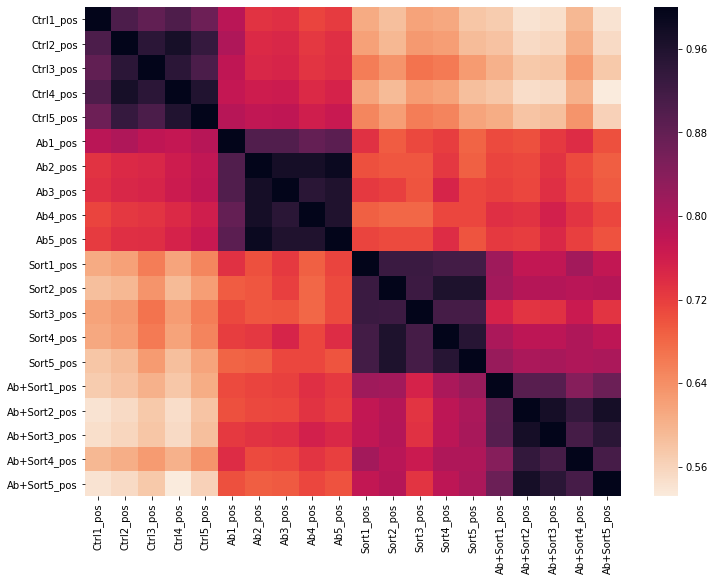

In [11]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


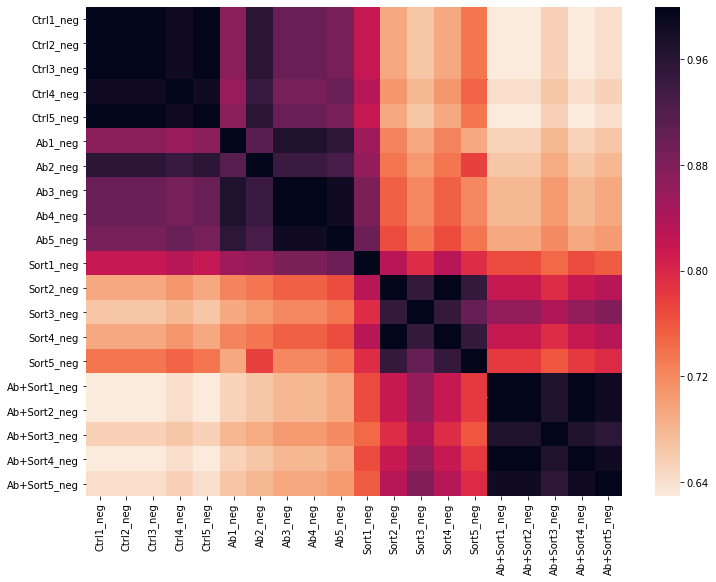

In [12]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [13]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=aligned_all_pos.cdl.unique_labels,
                     index=aligned_all_pos.cdl.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=aligned_all_neg.cdl.unique_labels,
                     index=aligned_all_neg.cdl.unique_labels)

Label similarity, positive mode


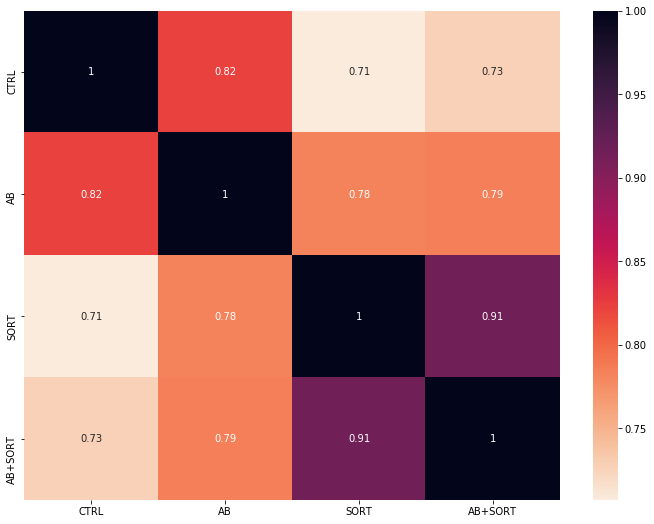

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


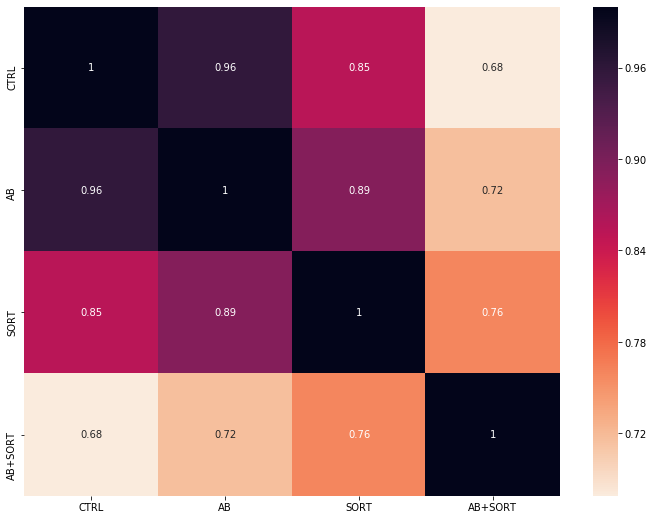

In [15]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Global metadata for consistency between tables and plots

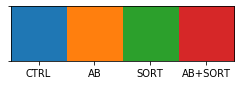

In [16]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab10', 4)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

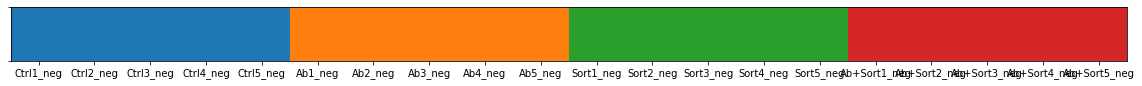

In [17]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3 types of processing are made:

Imp (Ionly) - Only Missing Value Imputation.

P - Missing Value Imputation and Pareto Scaling.

NGP - Missing Value Imputation, glog transformation and Pareto Scaling.

Since the state of the data we have is unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in previous dataset and the "absence of treatment" in the data is also tested since most of these dataset already suffered some kind of treatment.

In [18]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    #NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    #dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [19]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos)

## Similarity analysis (Jaccard)

In [20]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

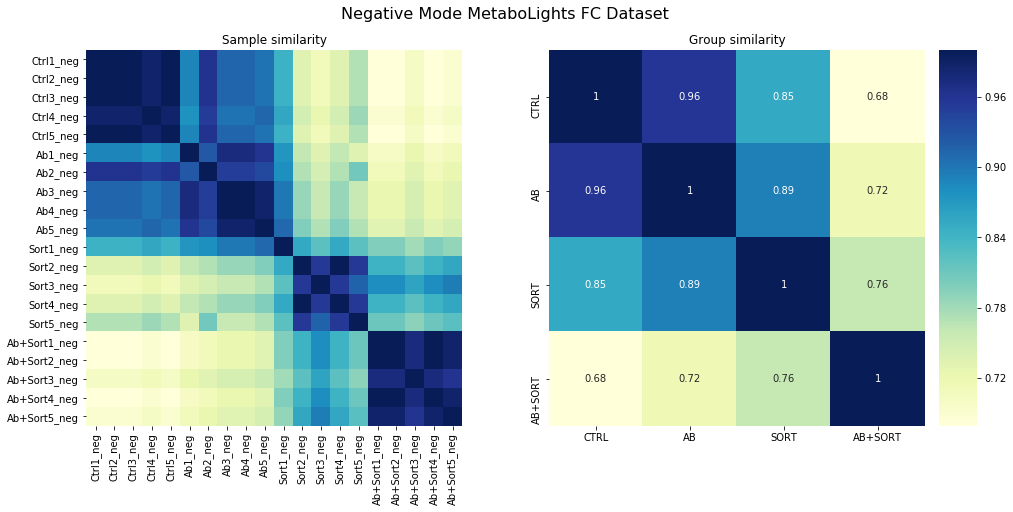

In [21]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode MetaboLights FC Dataset')

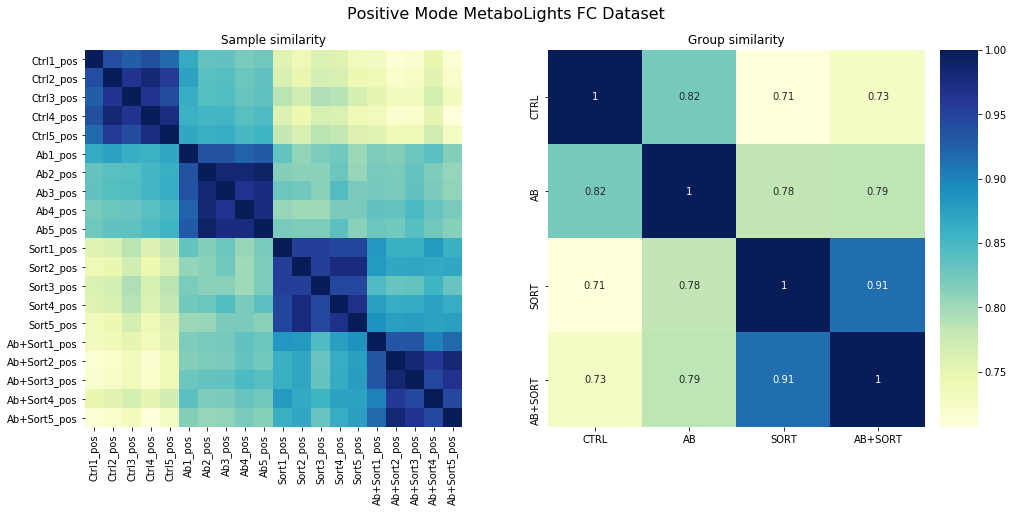

In [22]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode MetaboLights FC Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [23]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = 0.96522)


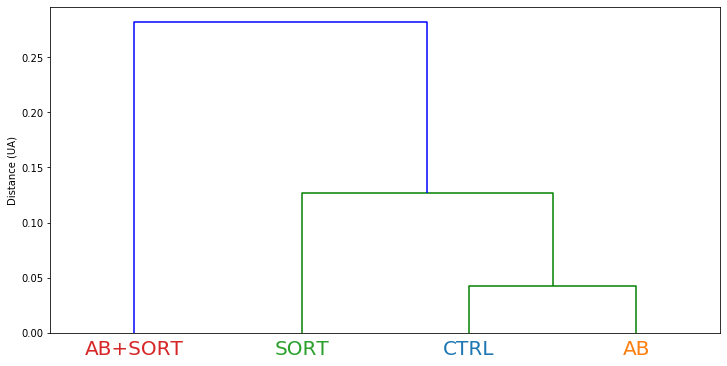

In [24]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode MetaboLights FC Dataset - Alignment: 1-6 (cophenetic = 0.90949)


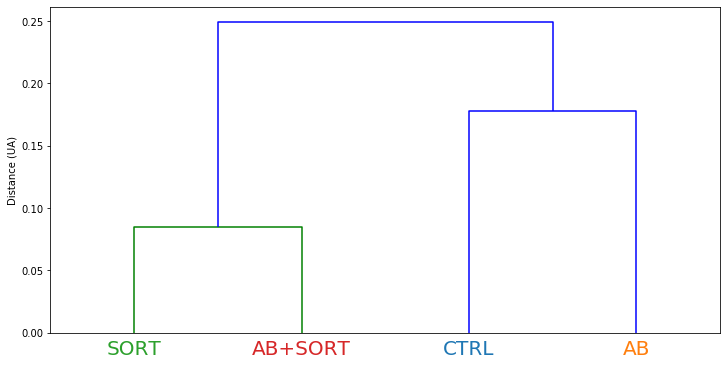

In [25]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode MetaboLights FC Dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation with the function fillna_frac_min(dataset, fraction=0.5) of transformation from metabolinks (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where different processing methods were applied in different combinations:

##### Glog transformation/ log2 transformation (glog from transformations in metabolinks) - G;
##### Pareto Scaling (pareto_scale from transformations in metabolinks) - P.
Three combinations were used and compared: No treatment (Imp), only Pareto Scaling (P) and glog transformation and Pareto Scaling (NGP).

In [26]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, leaf_rotation = 45, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - Dendograms with each differently-treated Grapevine Dataset

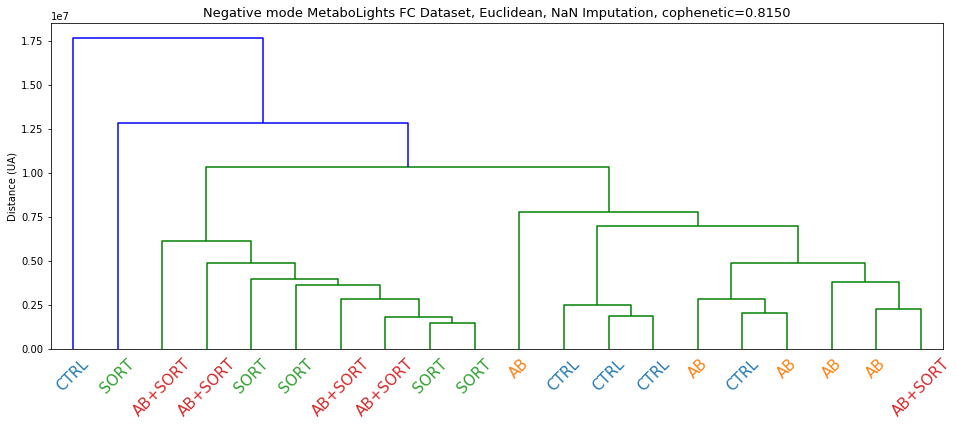

In [27]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

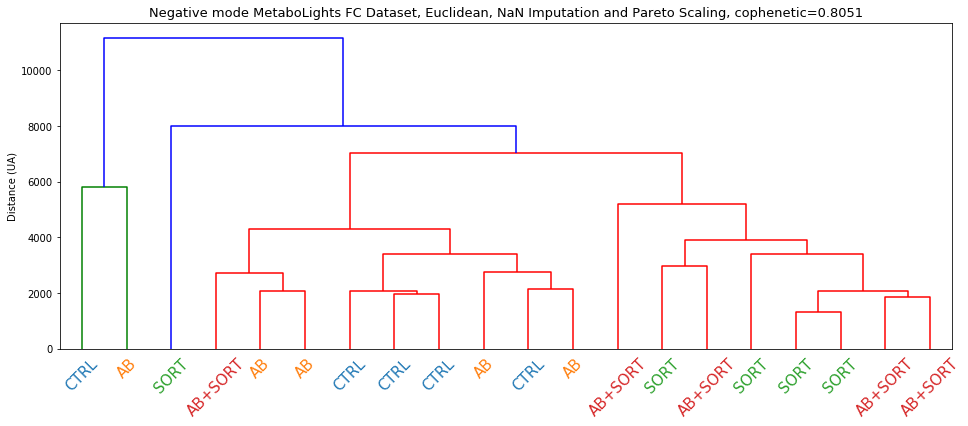

In [28]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

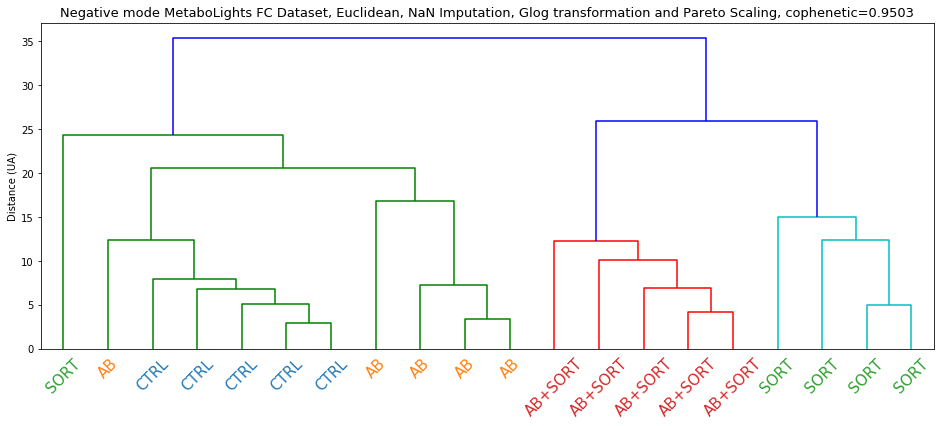

In [29]:
# Imputed, glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

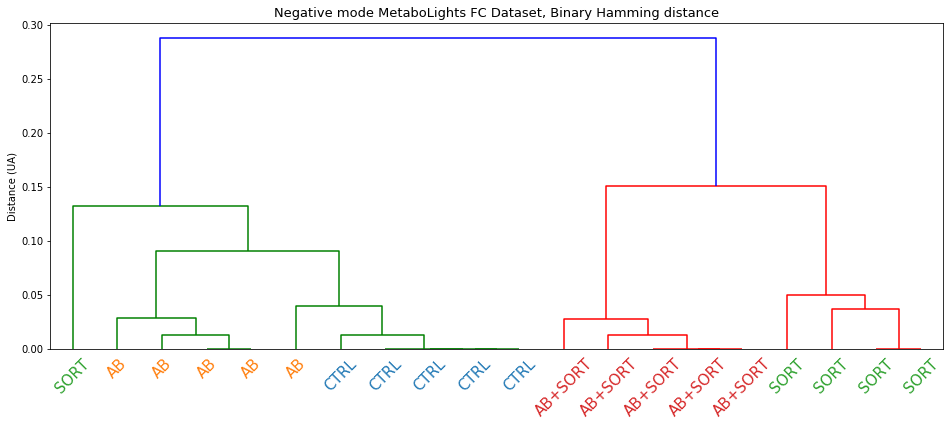

In [30]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative mode MetaboLights FC Dataset, Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - Dendograms with each differently-treated Grapevine Dataset

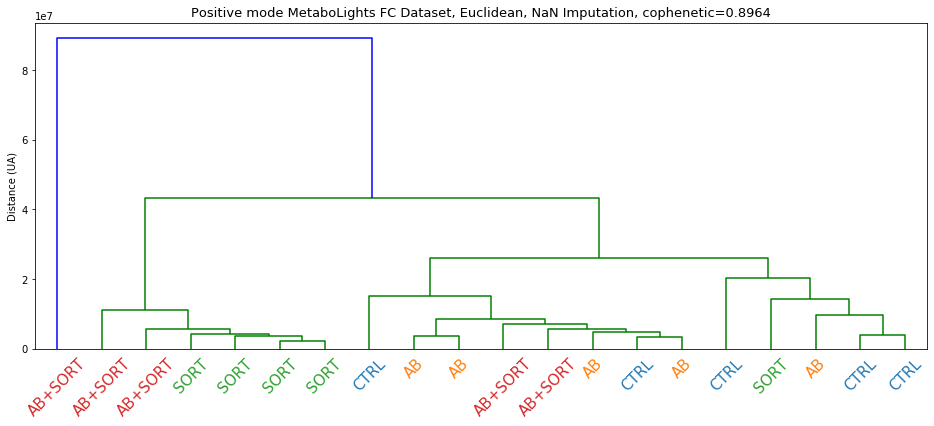

In [31]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive mode MetaboLights FC Dataset, Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

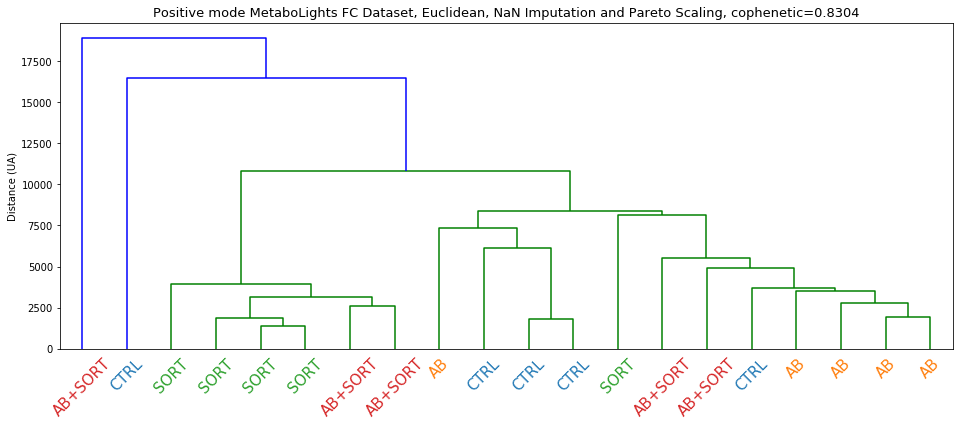

In [32]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive mode MetaboLights FC Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

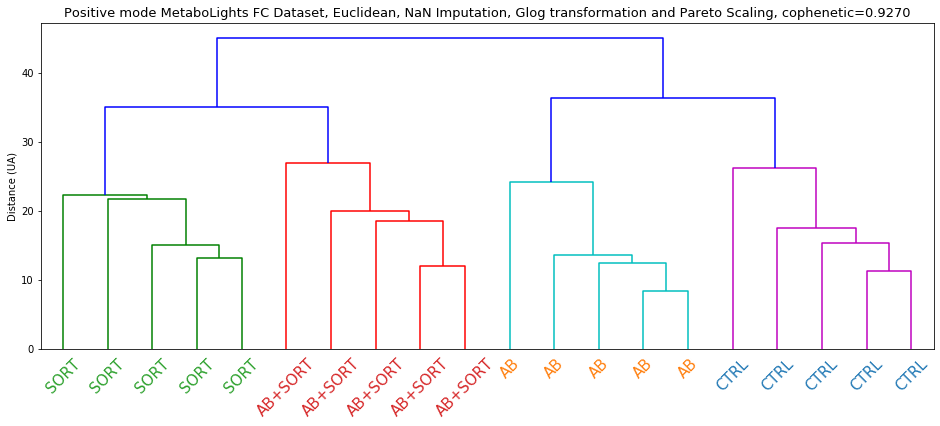

In [33]:
# Imputed, glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive mode MetaboLights FC Dataset, Euclidean, NaN Imputation, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

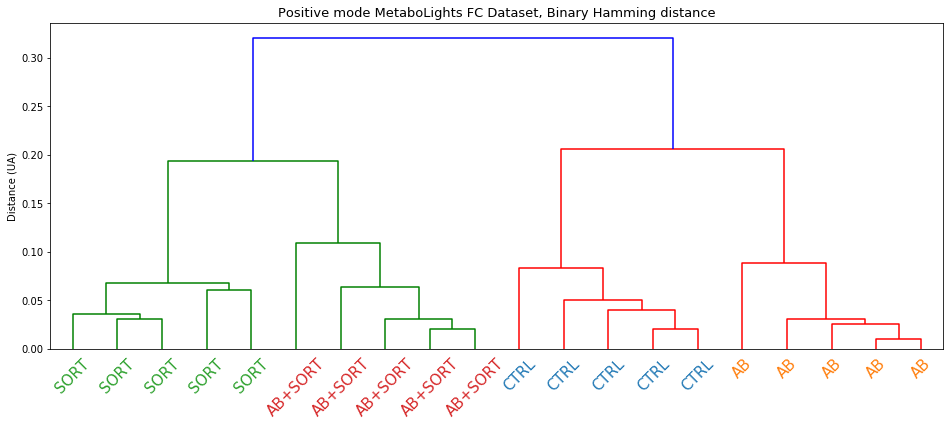

In [34]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive mode MetaboLights FC Dataset, Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [35]:
euclidean = (Z_Imp_neg, Z_P_neg, Z_NGP_neg, Z_Imp_pos, Z_P_pos, Z_NGP_pos)
dist_euclidean = (dist_Imp_neg, dist_P_neg, dist_NGP_neg, dist_Imp_pos, dist_P_pos, dist_NGP_pos)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [36]:
print('Pair of samples\tKendall Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp_neg-NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples	Kendall Correlation 	p-value
Imp_neg-P_neg  	 0.7626064346026121 	 5.126960001431431e-80
Imp_neg-NGP_neg	 0.25475650029201113 	 5.914504997200474e-10


According to the explanation given in the R package dendextend

In [37]:
print('Pair of samples\tSpearman Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp_neg-NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples	Spearman Correlation 	p-value
Imp_neg-P_neg  	 0.8415262981524682 	 3.961947697762646e-103
Imp_neg-NGP_neg	 0.3149480835303895 	 3.3908514692383237e-10


#### Cophenetic Correlation Coefficient

In [38]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [39]:
print('Pair of samples\tPearson Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp_neg-NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples	Pearson Correlation 	p-value
Imp_neg-P_neg  	 0.8106713672741706 	 1.4109515235550026e-45
Imp_neg-NGP_neg	 0.24891233762558337 	 0.0005340970900527171


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [40]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
#binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [41]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']

In [42]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [43]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [44]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [45]:
#Column names and row names for the dataframes
colnames = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg', 'euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos',
            'jaccard_neg', 'hamming_neg', 'yule_neg', 'jaccard_pos', 'hamming_pos', 'yule_pos']

In [46]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [47]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,6:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:6], line, df.iloc[6:]])
    prep = pd.concat([prep.iloc[:,:6], lineV.T, prep.iloc[:,6:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


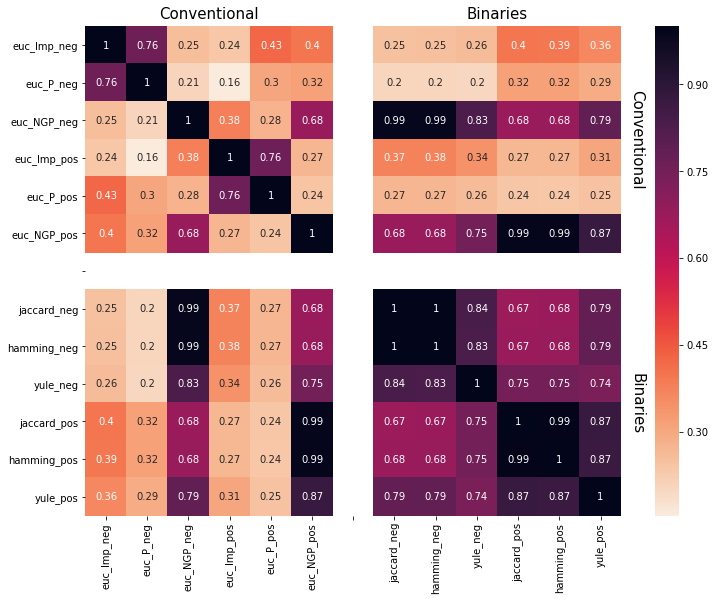

In [48]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


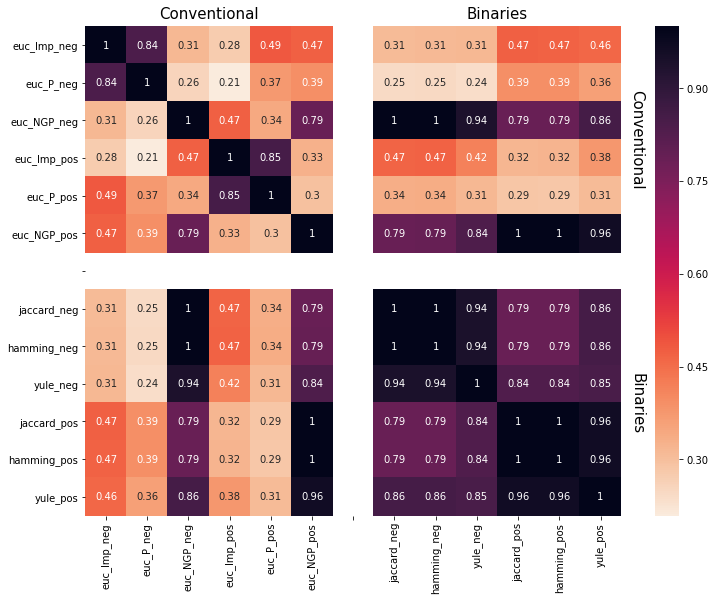

In [49]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


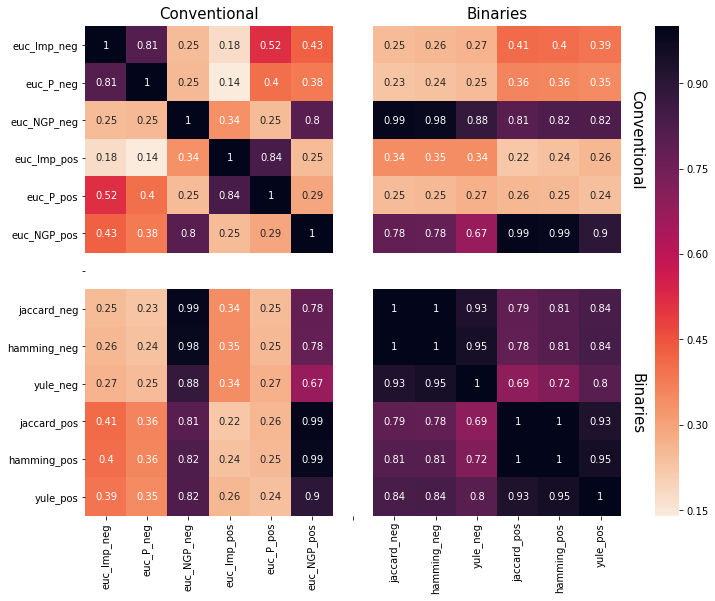

In [50]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: euclidean_neg, euclidean_pos, neg_binary, pos_binary)

In [51]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


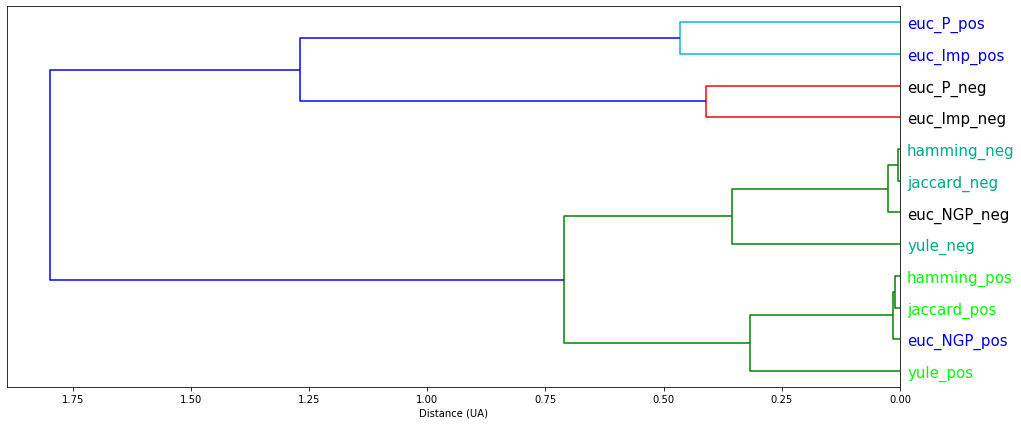

In [52]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=correlations['K'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


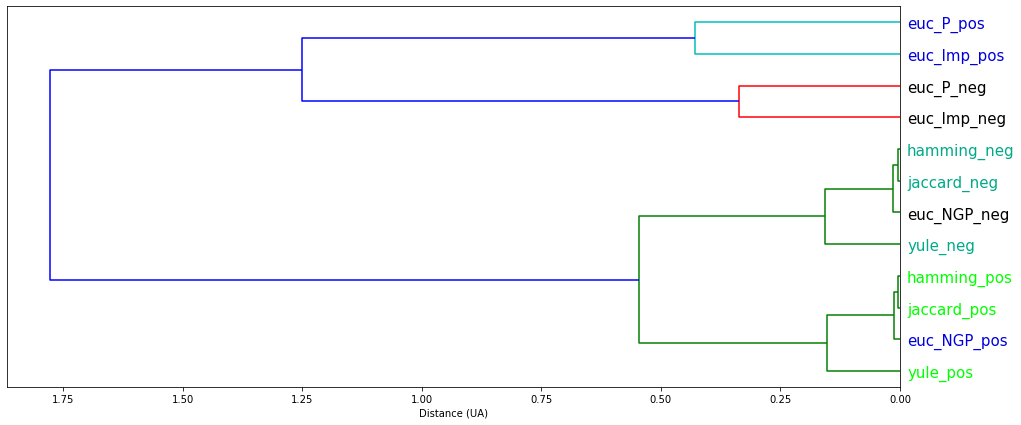

In [53]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=correlations['S'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


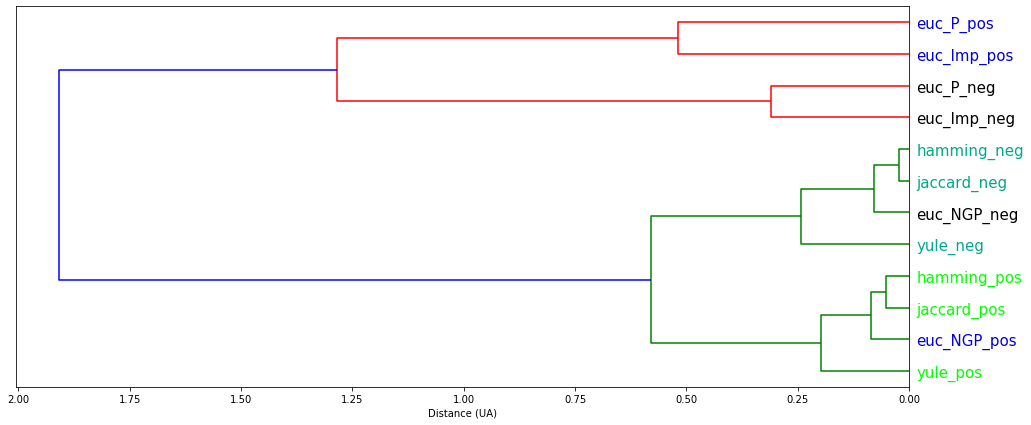

In [54]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=correlations['C'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [55]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [56]:
disc_average = np.zeros((1,12))
disc_median = np.zeros((1,12))
disc_correct = np.zeros((1,12))
for i in range(len(Z)):
    discrim = ma.dist_discrim(aligned_all_pos, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(aligned_all_pos, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)

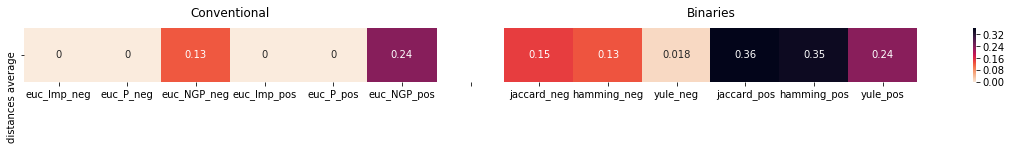

In [57]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

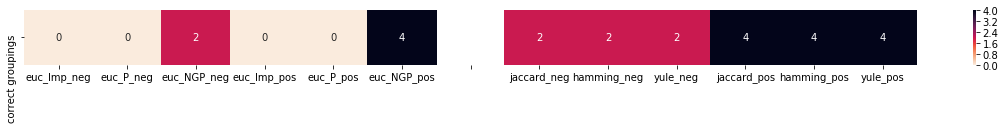

In [58]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [59]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [60]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [61]:
Kmean = skclust.KMeans(n_clusters=4)

In [62]:
a = Kmean.fit(NGP_neg.T)

In [63]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{1: ['CTRL', 'CTRL', 'CTRL', 'CTRL', 'CTRL', 'AB'],
 3: ['AB', 'AB', 'AB', 'AB', 'SORT'],
 0: ['SORT', 'SORT', 'SORT', 'SORT'],
 2: ['AB+SORT', 'AB+SORT', 'AB+SORT', 'AB+SORT', 'AB+SORT']}

Adjusted Rand Index

In [64]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.7332782824112304

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the `Kmeans_discrim` function from multianalysis to calculate discrimination distance.

In [65]:
colnames2 = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg', 'euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos',
             'aligned_neg', 'aligned_pos']

In [66]:
Data = (Imp_neg, P_neg, NGP_neg, Imp_pos, P_pos, NGP_pos, aligned_neg, aligned_pos)

In [67]:
disc_average = np.zeros((1,8))
disc_median = np.zeros((1,8))
disc_correct = np.zeros((1,8))
rand_index = np.zeros((1,8))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    Kmean = skclust.KMeans(n_clusters=4)
    a = Kmean.fit(Data[i].T)
    rand_index[0,i] = adjusted_rand_score(Data[i].cdl.labels,a.labels_)

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)
rand_index = pd.DataFrame(rand_index, index = ['correct groupings'], columns = colnames2)

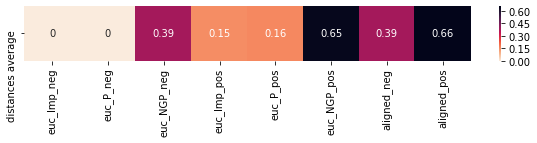

In [68]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [69]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

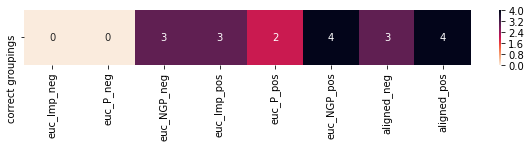

In [70]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

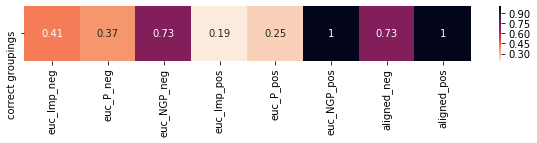

In [71]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(rand_index, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 5-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [72]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,450,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 5)

In [73]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

In [74]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg ... Done!
Fitting P_neg ... Done!
Fitting NGP_neg ... Done!
Fitting bin_neg ... Done!
Fitting I_pos ... Done!
Fitting P_pos ... Done!
Fitting NGP_pos ... Done!
Fitting bin_pos ... Done!


Performance based on number of trees - Negative Mode


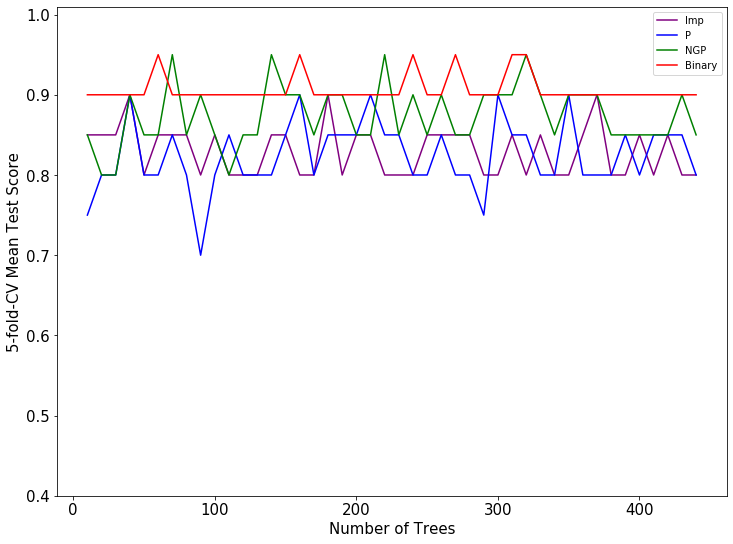

In [75]:
f, ax = plt.subplots(figsize=(12,9))
color = ['purple','blue','green','red']*2
for i in range(0,4):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('5-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Negative Mode')

Performance based on number of trees - Positive Mode


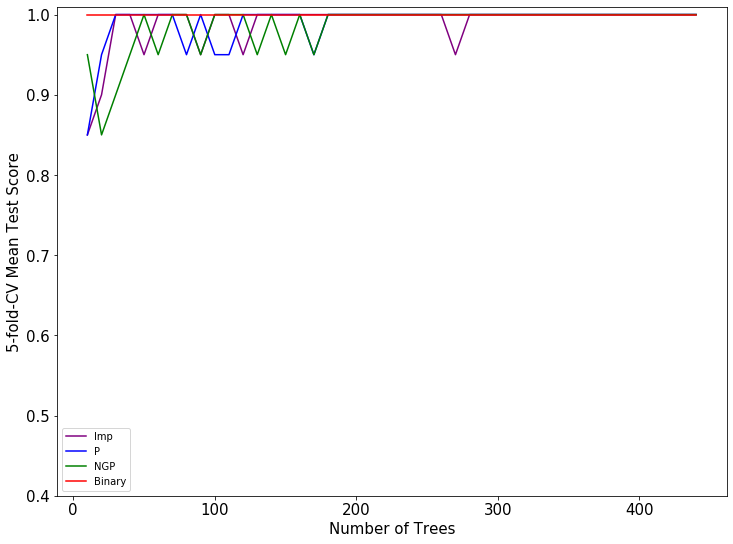

In [76]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(4,8):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('5-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Positive Mode')

### Performance of N, NP and NGP data treatments

See performance of all treatments and absence of them using method nº1 (simple application of random forests), see below.

In [77]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [78]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, n_fold = 5) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done
Fitting random forest for I_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for bin_pos ...done


Accuracy based on the dataset


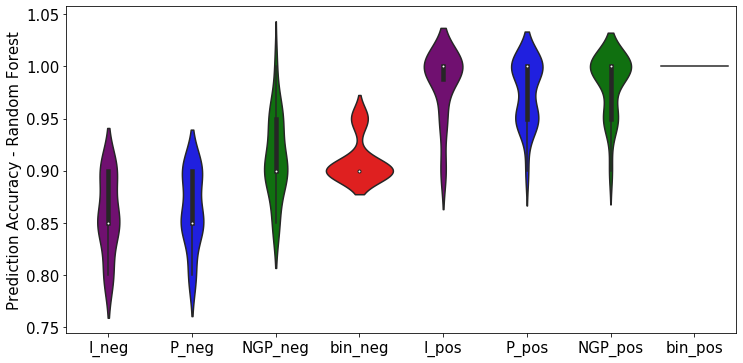

In [79]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(Teste), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

In [80]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

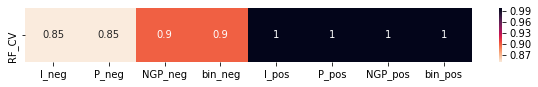

In [81]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

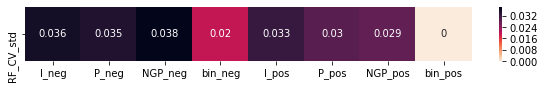

In [82]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

Accuracy plot with errors bars corresponding to the 95% confidence interval and accurcy and standard deviation tables

In [83]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

In [84]:
#sns.set_context('notebook')

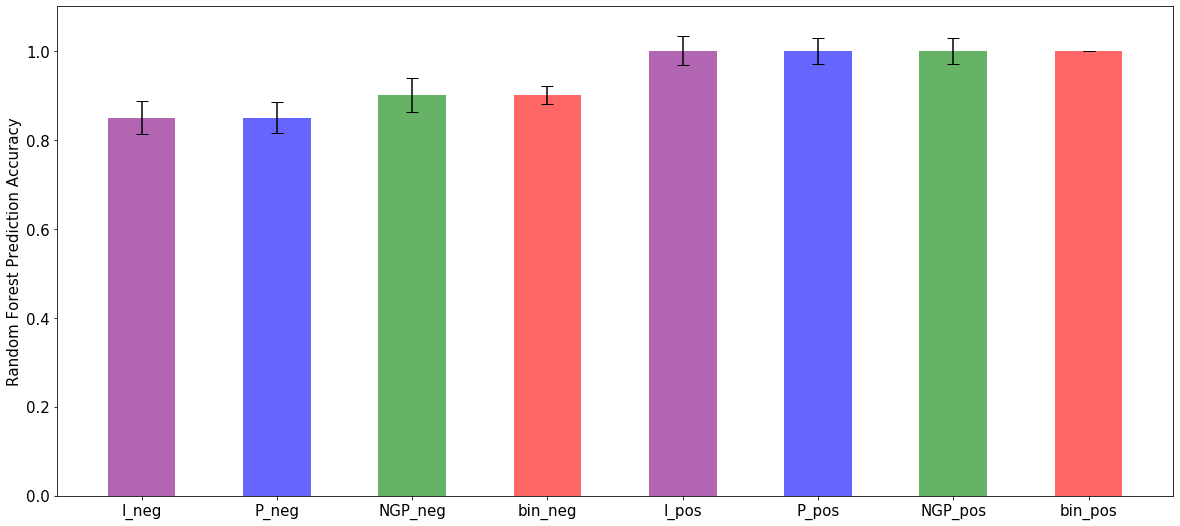

In [85]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Attempt/Method nº1 - Direct

### Simple application of random forests

The random forest classification is iterated iter_num times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained. 

N-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/prediction accuracy - the number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Besides the n-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Application of the function `simple_RF` from multianalysis.

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 5). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [86]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [87]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

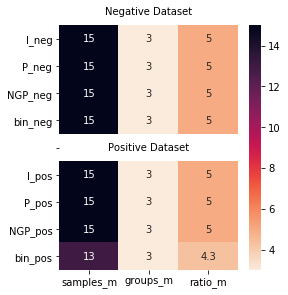

In [88]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

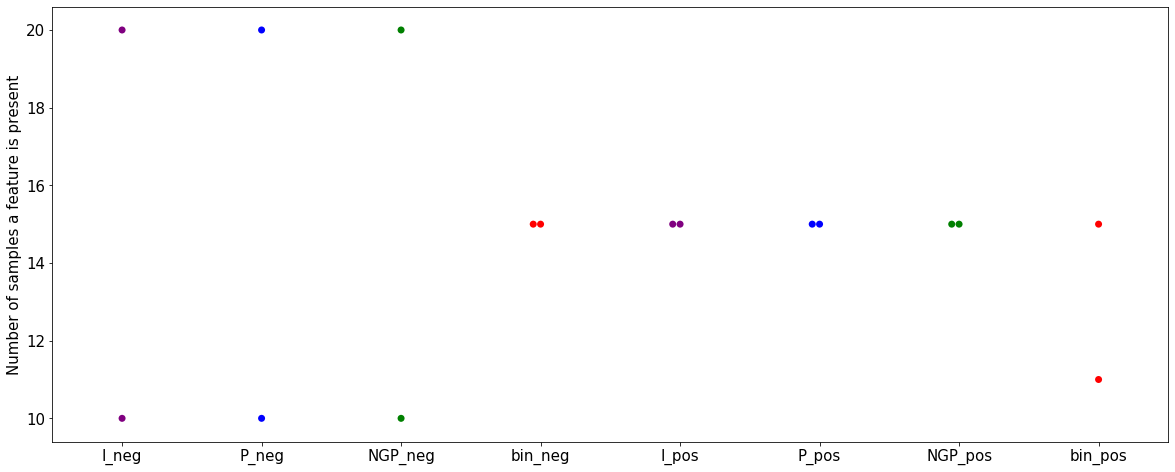

In [89]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 7, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [90]:
print('Magnitude of most important feature:', )
for i in range(8):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(8):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg      	 1.8016749777981584
P_neg      	 1.7067392125300822
NGP_neg      	 1.7862705235932552
bin_neg      	 5.701096251013131
I_pos      	 2.5449769161636713
P_pos      	 2.3794404550992247
NGP_pos      	 2.4557649514445905
bin_pos      	 3.411990742980985


% of model explained by the 2% most important features
I_neg      	 4.185482441166767
P_neg      	 4.168903704372276
NGP_neg      	 4.1884115167891025
bin_neg      	 14.056656432683237
I_pos      	 5.02503573980494
P_pos      	 4.756523006730653
NGP_pos      	 4.9040330399901535
bin_pos      	 6.759304911037966


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with n-fold cross-validation (same judgement as the one done in the random forests for the cross-validation). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [91]:
PLS_optim = {}

In [92]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10, n_fold = 5)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for I_neg ...done
Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for bin_neg ...done
Optimizing PLS-DA for I_pos ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for bin_pos ...done


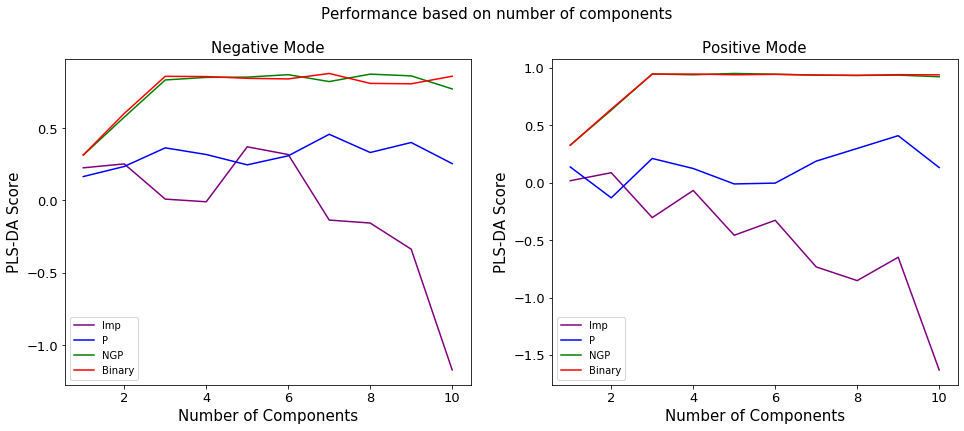

In [93]:
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)
color = ['purple','blue','green','red']*2
i = 0

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        quadrant[0].plot(range(1,11),data, color[i])
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Imp', 'P', 'NGP', 'Binary'))
    if name.endswith('pos'):
        quadrant[1].plot(range(1,11),data, color[i])
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Imp', 'P', 'NGP', 'Binary'))
    i = i+1

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better was the numebr of components used in each case. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in k different groups as k-fold cross-validation.

In [94]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [95]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 3, iter_num = 100, n_fold = 5, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for I_neg ...done
Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for bin_neg ...done
Fitting PLS-DA for I_pos ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for bin_pos ...done


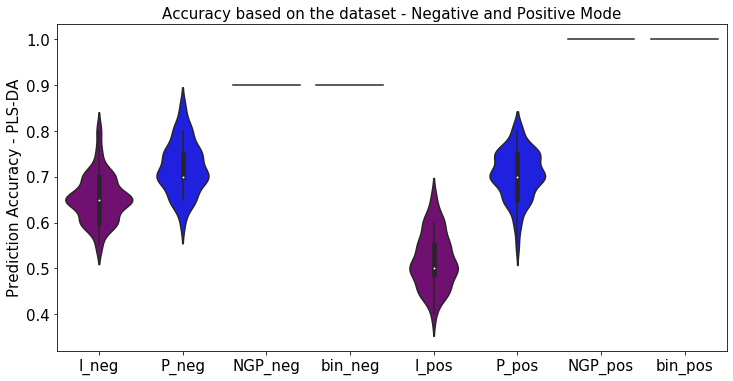

In [96]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
plt.title('Accuracy based on the dataset - Negative and Positive Mode', fontsize = 15)
plt.show()

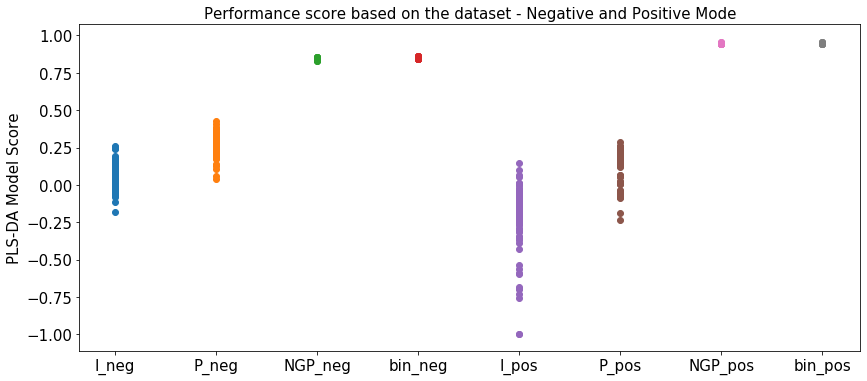

In [97]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Negative and Positive Mode', fontsize = 15)
plt.show()

### Medians but also still with standard deviations

In [98]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

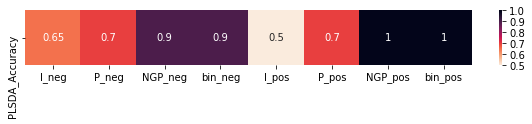

In [99]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.show()

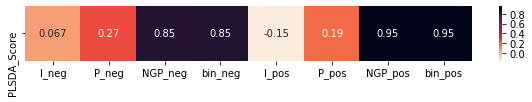

In [100]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [101]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
I_neg,0.65,5.090187e-02
P_neg,0.70,5.656854e-02
NGP_neg,0.90,4.440892e-16
bin_neg,0.90,4.440892e-16
I_pos,0.50,5.895761e-02
P_pos,0.70,5.342986e-02
NGP_pos,1.00,0.000000e+00
bin_pos,1.00,0.000000e+00


In [102]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
I_neg,0.067215,0.080439
P_neg,0.265397,0.068746
NGP_neg,0.845860,0.005321
bin_neg,0.852145,0.004348
I_pos,-0.147508,0.210443
P_pos,0.192731,0.106761
NGP_pos,0.948496,0.002023
bin_pos,0.948840,0.001936


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [103]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [104]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

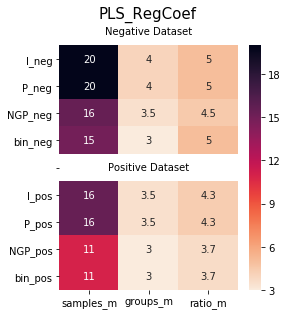

In [105]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'Negative Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

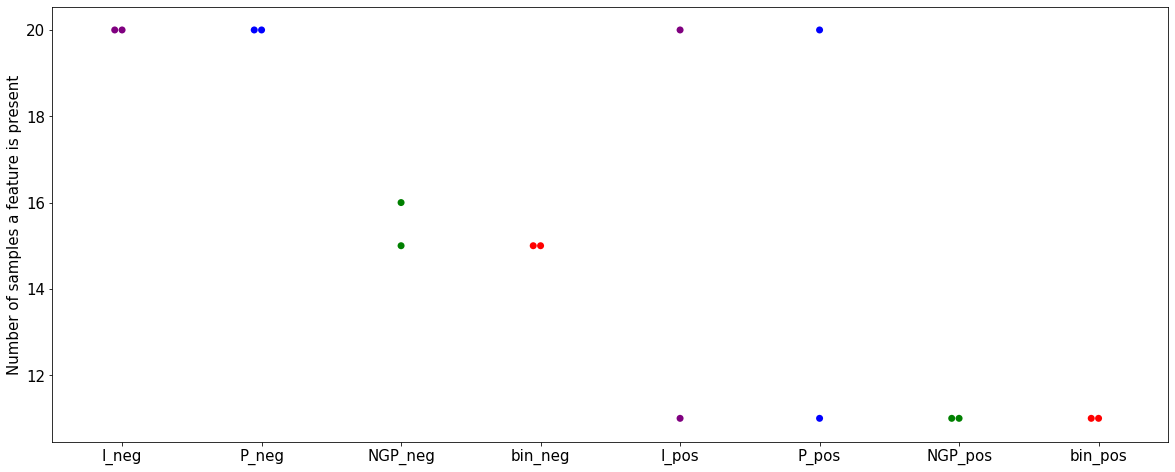

In [106]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 7, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [107]:
print('Magnitude of most important features for each case:')
for i in range(8):
    print(list(PLS_feat.keys())[i], '     \t', magni[i])

Magnitude of most important features for each case:
I_neg      	 8.060763036605715
P_neg      	 6.391806426004946
NGP_neg      	 3.5609886146403875
bin_neg      	 4.223693665725307
I_pos      	 11.882901350927392
P_pos      	 6.662930252088796
NGP_pos      	 3.7827563278301337
bin_pos      	 4.3421574499179085


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [108]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode

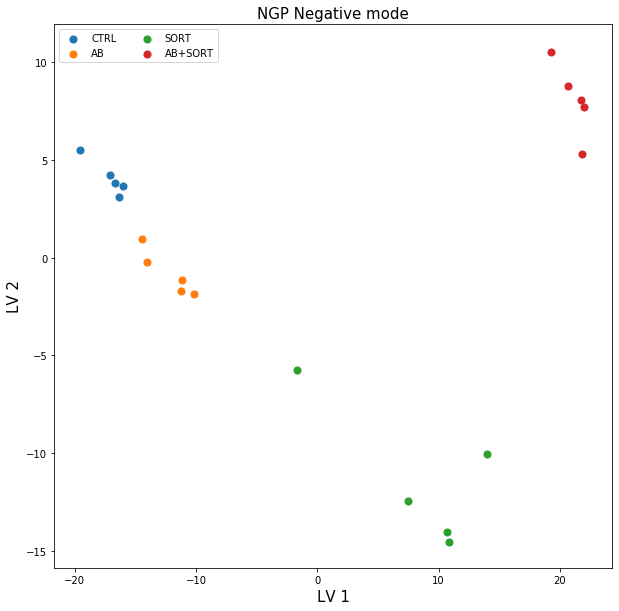

In [109]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode

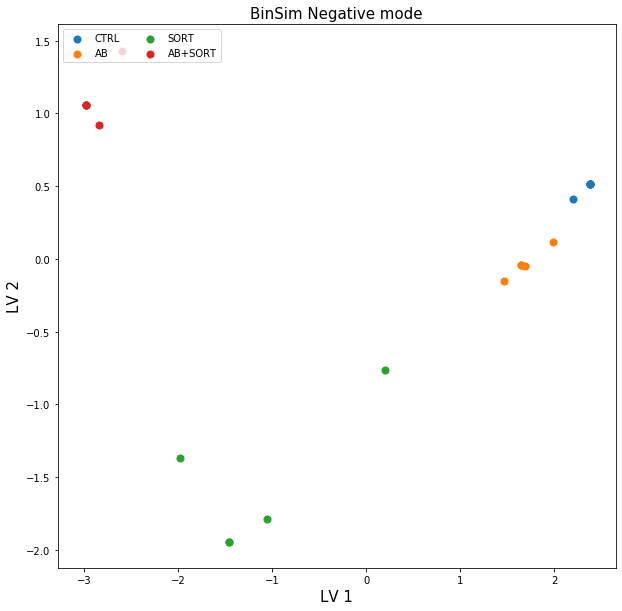

In [110]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the Positive Mode

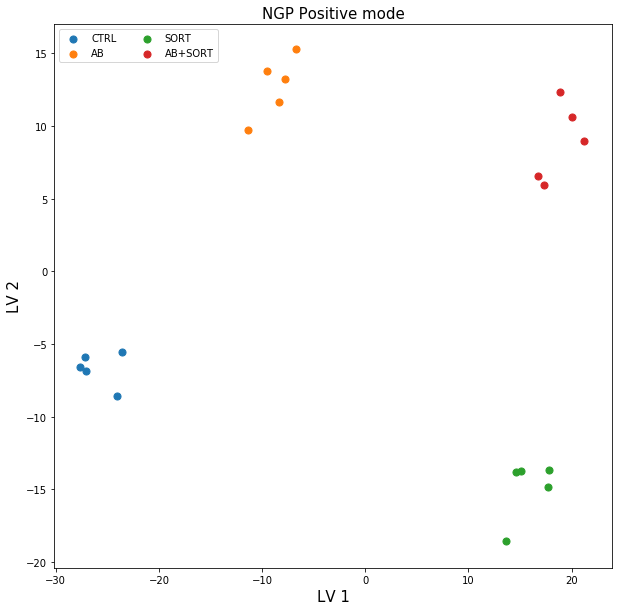

In [111]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_pos, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Positive mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the positive mode

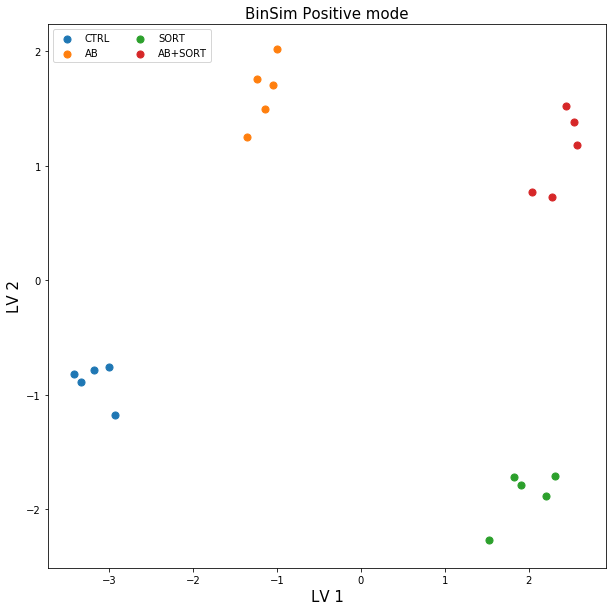

In [112]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(aligned_pos, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Positive mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [113]:
CV = {}
PMs = {}
pvalue = {}

In [114]:
all_data = (Imp_neg, P_neg, NGP_neg, aligned_neg, Imp_pos, P_pos, NGP_pos, aligned_pos)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg', 'Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=5)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp_neg ...
Done!
Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!
Permutation test (Random Forest) for Imp_pos ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for bin_pos ...
Done!


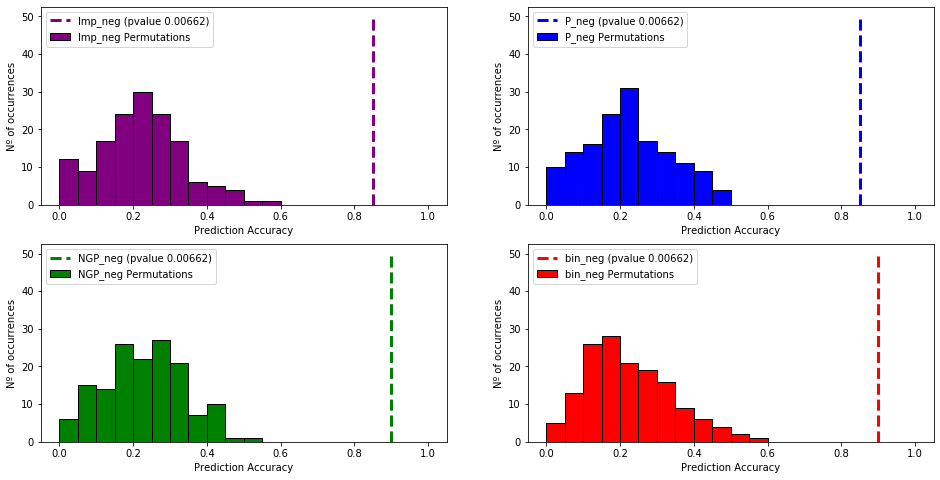

In [115]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

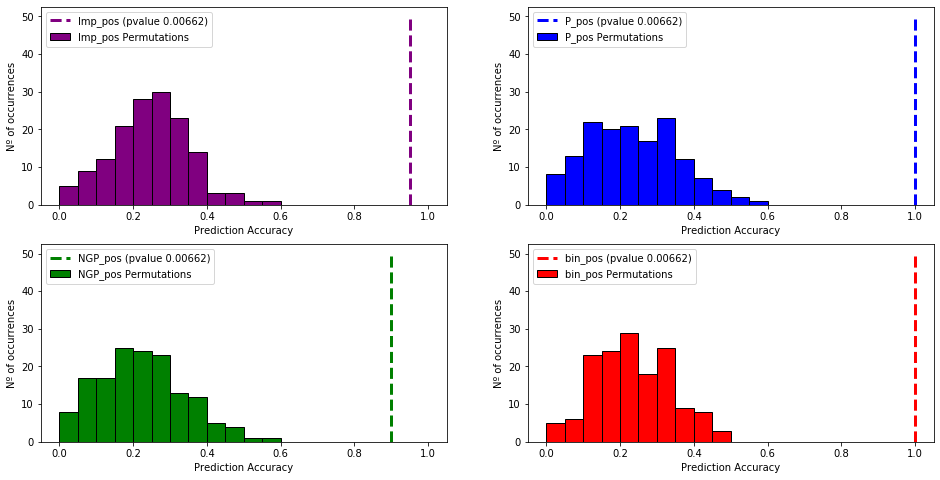

In [116]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [117]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [118]:
all_data = (Imp_neg, P_neg, NGP_neg, aligned_neg, Imp_pos, P_pos, NGP_pos, aligned_pos)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg', 'Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp = 4, iter_num = 150, n_fold = 5)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp_neg ...
Done!
permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...
Done!
permutation test (PLS-DA) for Imp_pos ...
Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NGP_pos ...
Done!
permutation test (PLS-DA) for bin_pos ...
Done!


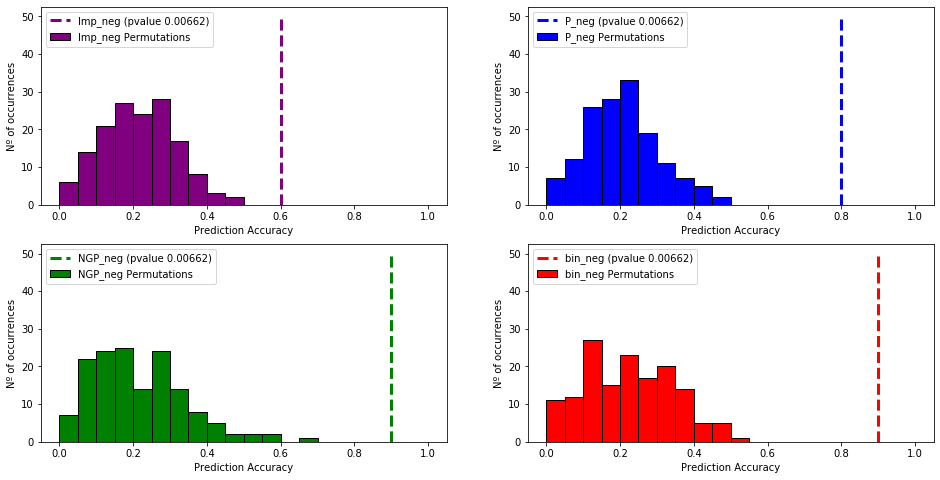

In [119]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

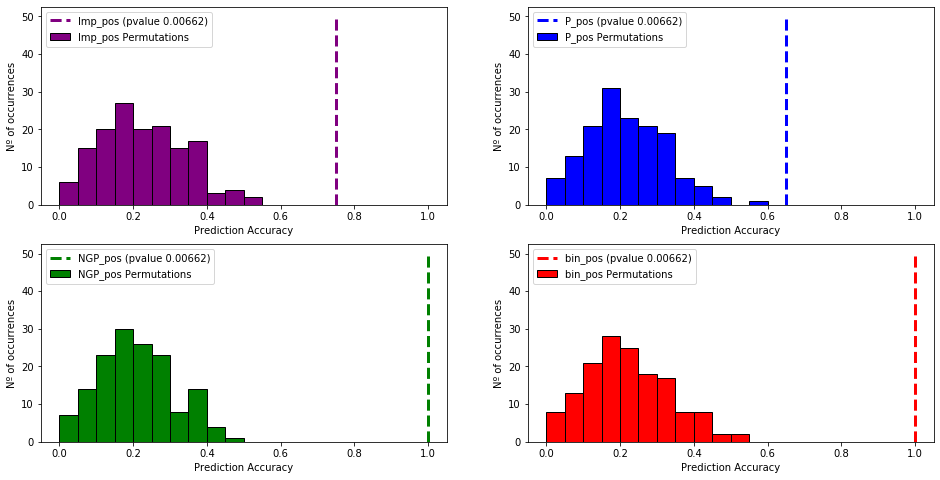

In [120]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

In [121]:
def dist_discrim(Spectra, Z, method='average'):
    """Gives a measure of the normalized distance that a group of samples (same label) is from all other samples in hierarchical clustering.

       This function calculates the distance from a certain number of samples with the same label to the closest samples using the 
    hierarchical clustering linkage matrix and the labels (in Spectra) of each sample. For each set of samples with the same label, it 
    calculates the difference of distances between where the cluster with all the set of samples was formed and the cluster that joins 
    those set of samples with another samples. The normalization of this distance is made by dividing said difference by the max 
    distance between any two cluster. If the samples with the same label aren't all in the same cluster before any other sample joins 
    them, the distance given to this set of samples is zero. It returns the measure of the normalized distance as well as a dictionary 
    with all the calculated distances for all set of samples (labels).

       Spectra: AlignedSpectra object (from metabolinks).
       Z: ndarray; hierarchical clustering linkage matrix (from scipy.cluster.hierarchical.linkage)
       method: str; Available methods - "average", "median". This is the method to give the normalized discrimination distance measure
    based on the distances calculated for each set of samples.

       Returns: (scalar, dictionary); normalized discrimination distance measure, dictionary with the discrimination distance for each
    set of samples.
    """

    # Creating dictionaries with the clusters formed at iteration r and the distance between the elements of said cluster.
    dists = {}
    clust = {}
    for i in range(0, len(Z)+1):
        clust[i] = (float(i),)
    for r in range(0, len(Z)):
        clust[len(Z)+1+r] = clust[Z[r, 0]] + clust[Z[r, 1]]
        dists[len(Z)+1+r] = Z[r, 2]
        
    sample_number = {}
    for i in Spectra.unique_labels():
        sample_number[i] = Spectra.labels.count(i)

    # Calculating discriminating distances of a set of samples with the same label and storing in a dictionary.
    separaT = 0
    separa = dict(zip(Spectra.unique_labels(), [
                  0] * len(Spectra.unique_labels())))
    for i in clust:
        label = [Spectra.labels[int(clust[i][j])]
                     for j in range(len(clust[i]))]
        if len(clust[i]) == sample_number[label[0]]:
            #label = [Spectra.labels[int(clust[i][j])]
                     #for j in range(sample_number)]
            # All labels must be the same.
            if label.count(label[0]) == len(label):
                itera = np.where(Z == i)[0][0]
                dif_dist = Z[itera, 2]
                separa[label[0]] = (dif_dist-dists[i])/Z[-1, 2]#Z[-1,2] - maximum distance between 2 clusters.
                separaT = separaT + separa[label[0]]

    # Method to quantify a measure of a global discriminating distance for a linkage matrix.
    if method == 'average':
        separaM = separaT/len(Spectra.unique_labels())
    elif method == 'median':
        separaM = np.median(list(separa.values()))
        if separaM == 0:
            separaM = None
    else:
        raise ValueError(
            'Method not recognized. Available methods: "average", "median".')

    return separaM, separa